# CNN on CIFAR10

In [46]:
import torch
import torchvision
import torchsummary
import numpy as np
import seaborn as sn
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

## General Constants

In [47]:
BATCH_SIZE = 200
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
DROPOUT_RATE = 0.6
LEARNING_RATE = 0.001
N_EPOCHS = 20
PATH = '.cifar_model.pth'
TRAIN_VAL_SPLIT = [45000, 5000]

## Loading the data

In [48]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

train_set, val_set = torch.utils.data.random_split(train_set, TRAIN_VAL_SPLIT)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

test_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

Files already downloaded and verified
Files already downloaded and verified


## The Model

In [49]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=3,
                out_channels=32,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=1,
                padding=1,
                stride=1
            ),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout(DROPOUT_RATE),
            torch.nn.Flatten(),
            torch.nn.Linear(
                in_features=256*4*4,
                out_features=1024
            ),
            torch.nn.ReLU(),
            torch.nn.Linear(
                in_features=1024,
                out_features=512
            ),
            torch.nn.ReLU(),
            torch.nn.Linear(
                in_features=512,
                out_features=10
            ),
        )

    def forward(self, x):
        return self.network(x)

In [50]:
model = Model()

torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7          [-1, 128, 18, 18]           8,320
              ReLU-8          [-1, 128, 18, 18]               0
            Conv2d-9          [-1, 128, 18, 18]         147,584
             ReLU-10          [-1, 128, 18, 18]               0
        MaxPool2d-11            [-1, 128, 9, 9]               0
      BatchNorm2d-12            [-1, 128, 9, 9]             256
           Conv2d-13            [-1, 256, 9, 9]         295,168
             ReLU-14            [-1, 25

In [51]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training loop

In [52]:
accuracy_hist = []
loss_hist = []
val_accuracy_hist = []
val_los_hist = []

for epoch in range(N_EPOCHS):
    training_cost = 0.0
    training_correct = 0.0
    validation_cost = 0.0
    validation_correct = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        predictions = model(inputs)
        cost = loss_func(predictions, targets)
        cost.backward()
        optimizer.step()
        training_cost += cost.item()
        training_correct += (torch.argmax(predictions, dim=1) == targets).sum()
    training_cost /= len(train_set)
    training_correct /= len(train_set)
    print(f'epoch: {epoch}, loss: {training_cost}, accuracy: {training_correct}')
    accuracy_hist.append(training_correct)
    loss_hist.append(training_cost)

    with torch.no_grad():
        for inputs, targets in val_loader:
            predictions = model(inputs)
            cost = loss_func(predictions, targets)
            validation_cost += cost.item()
            validation_correct += (torch.argmax(predictions, dim=1) == targets).sum()
        validation_cost /= len(val_set)
        validation_correct /= len(val_set)
        print(f'Validation: loss: {validation_cost}, accuracy: {validation_correct}')
        val_accuracy_hist.append(validation_correct)
        val_los_hist.append(validation_cost)

epoch: 0, loss: 0.006890789280997382, accuracy: 0.49675557017326355
Validation: loss: 0.005545469844341278, accuracy: 0.5982000231742859
epoch: 1, loss: 0.004803465252452427, accuracy: 0.6566666960716248
Validation: loss: 0.004158462691307068, accuracy: 0.7024000287055969
epoch: 2, loss: 0.003959168840779199, accuracy: 0.7200222015380859
Validation: loss: 0.003692583203315735, accuracy: 0.7391999959945679
epoch: 3, loss: 0.0034790138092305927, accuracy: 0.757111132144928
Validation: loss: 0.003252065336704254, accuracy: 0.7724000215530396
epoch: 4, loss: 0.0030834880106978945, accuracy: 0.7832221984863281
Validation: loss: 0.0030674819827079774, accuracy: 0.7954000234603882
epoch: 5, loss: 0.0028725482172436184, accuracy: 0.800777792930603
Validation: loss: 0.0028721318185329437, accuracy: 0.8027999997138977
epoch: 6, loss: 0.0026281583110491433, accuracy: 0.8168888688087463
Validation: loss: 0.0026880275189876558, accuracy: 0.8144000172615051
epoch: 7, loss: 0.002426443987422519, accu

## Save the trained model

In [53]:
torch.save(model.state_dict(), PATH)

## Viszualizing the training

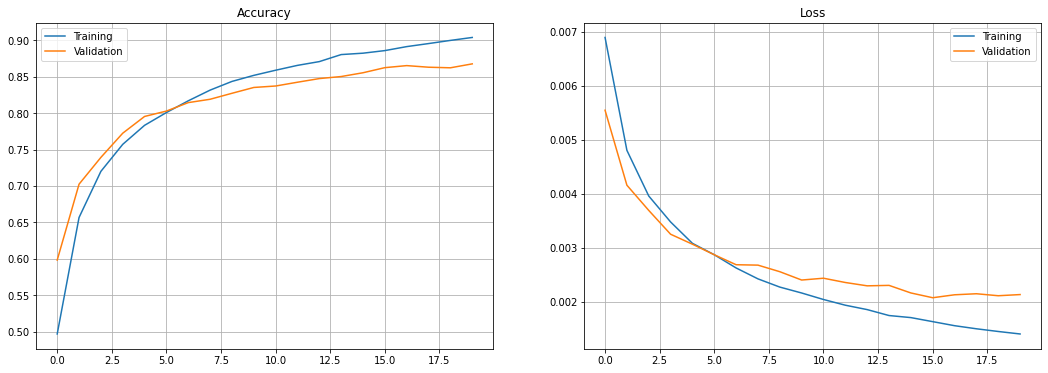

In [54]:
f = plt.figure(figsize=(18, 6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(accuracy_hist, label='Training')
ax1.plot(val_accuracy_hist, label='Validation')
ax1.title.set_text('Accuracy')
ax1.legend()
ax1.grid()
ax2.plot(loss_hist, label='Training')
ax2.plot(val_los_hist, label='Validation')
ax2.title.set_text('Loss')
ax2.legend()
ax2.grid()

## Load the trained model

In [55]:
model = Model()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Testing the model

In [56]:
correct = 0

targs = []
preds = []

with torch.no_grad():
    for inputs, targets in test_loader:
        predictions = model(inputs)
        torch.argmax(predictions)
        correct += (torch.argmax(predictions, dim=1) == targets).sum()
        targs.extend(targets)
        preds.extend(torch.argmax(predictions, dim=1))

print(f'Accuracy on training set: {correct / len(test_set)}')

Accuracy on training set: 0.8532999753952026


## Confusion matrix

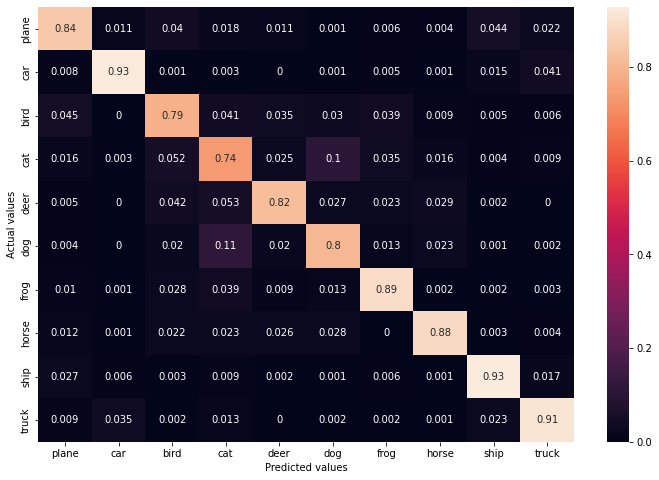

In [57]:
cf_matrix = confusion_matrix(targs, preds)

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 10, index=[i for i in CLASSES], columns=[i for i in CLASSES])

plt.figure(figsize=(12, 8))
ax = sn.heatmap(df_cm, annot=True)
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')

plt.show()

## Log

|   Model   |   Batch Size  |   Learning Rate   |   Epochs  |   Random Transforms   |   Random Rotations    |   Training Accuracy   |   Test Accuracy   |
|-----------|--------------:|------------------:|----------:|:---------------------:|:---------------------:|----------------------:|------------------:|
|   Layer 1: Conv2d, Layer 2: ReLU, Layer 3: MaxPool2d, Layer 4: Flatten, Layer 5: Linear, Layer 6: Softmax |   300 |   0.001   |   30   |   yes |   yes |   62% |   61% |
|   Layer 1: Conv2d, Layer 2: ReLU, Layer 3: MaxPool2d, Layer 4: Flatten, Layer 5: Linear, Layer 6: Softmax |   300 |   0.001   |   30   |   no |   no |   77% |   64% |
|   Layer 1: Conv2d, Layer 2: ReLU, Layer 3: Conv2d, Layer 4: ReLU, Layer 5: MaxPool2d, Layer 6: Flatten, Layer 7: Linear, Layer 8: Softmax |   200 |   0.001   |   18   |   no |   no |   88% |   67% |
|   Layer 1: Conv2d, Layer 2: ReLU, Layer 3: Conv2d, Layer 4: ReLU, Layer 5: MaxPool2d, Layer 6: Flatten, Layer 7: Linear, Layer 8: Softmax |   200 |   0.001   |   20   |   yes |   yes |   63% |   62% |
|   Layer 1: Conv2d, Layer 2: ReLU, Layer 3: MaxPool2d, Layer 4: Flatten, Layer 5: Linear, Layer 6: Softmax |   200 |   0.001   |   30   |   no |   no |   79% |   65% |
|   Layer 1: Conv2d, Layer 2: ReLU, Layer 3: Conv2d, Layer 4: ReLU, Layer 5: MaxPool2d, Layer 6: Dropout2d, Layer 7: Flatten, Layer 8: Linear, Layer 9: Softmax |   200 |   0.001   |   20   |   no |   no |   51% |   49% |
|   Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d -> BatchNorm2d -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d -> BatchNorm2d -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d -> BatchNorm2d -> Flatten -> Linear -> ReLU -> Linear -> ReLU -> Linear |   200 |   0.001   |   10   |   no |   no |   98% |   81% |
|   Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d -> BatchNorm2d -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d -> BatchNorm2d -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d -> BatchNorm2d -> Dropout -> Flatten -> Linear -> ReLU -> Linear -> ReLU -> Linear |   200 |   0.001   |   10   |   no |   no |   94% |   82% |
|   Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d -> BatchNorm2d -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d -> BatchNorm2d -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d -> BatchNorm2d -> Dropout -> Flatten -> Linear -> ReLU -> Linear -> ReLU -> Linear |   200 |   0.001   |   20   |   yes |   yes |   90% |   85% |

Random transforms and rotations seem to decrease the potential of overfitting, but also the resulting accuracy. Additionally, training time is much higher.